# Importing and Stuff

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the mapping of each letter

abc = '.abcdefghijklmnopqrstuvwxyz'
vocab_size = len(abc)

stoi = {s: i for i, s in enumerate(abc)}
itos = {i: s for s, i in stoi.items()}

In [4]:
# Shuffle the Words

import random
random.seed(42)
random.shuffle(words)

In [57]:
# build the databse
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training, dev and test split
# 80%   10%   10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182587, 8]) torch.Size([182587])
torch.Size([22709, 8]) torch.Size([22709])
torch.Size([22850, 8]) torch.Size([22850])


In [58]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> m
.......m ---> o
......mo ---> r
.....mor ---> g
....morg ---> a
...morga ---> n
..morgan ---> .
........ ---> f
.......f ---> i
......fi ---> l
.....fil ---> i
....fili ---> p
...filip ---> p
..filipp ---> o
.filippo ---> .
........ ---> m
.......m ---> a
......ma ---> i
.....mai ---> t
....mait ---> r


In [59]:
# Classes (or modules) for all the operations

# -----------------------------------------------------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5    # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

# -----------------------------------------------------------------------------------------------------------------------------------
class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))    # variance

    def __call__(self, x):
        # Calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)    # normalise to unit variance
        self.out = self.gamma * xhat + self.beta
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                # self.running_mean += self.momentum * (-self.running_mean + xmean)
                # self.running_var += self.momentum * (xvar - self.running_var)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        # if x.shape[1] == 1:
        x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # Returns parameters of all the layers and strteches them into 1 list
        return [p for layer in self.layers for p in layer.parameters()]


In [7]:
torch.manual_seed(42);    # same as generator

In [64]:
# Initialising the NN
n_embd = 24    # the dimensionality of the character embedding vector
n_hidden = 128    # the number of neurons in the hidden layer of MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# model = Sequential([
#     Embedding(vocab_size, n_embd),
#     FlattenConsecutive(block_size),
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print('We have', sum([p.nelement() for p in parameters]), 'number of parameters!')

for p in parameters:
    p.requires_grad = True
    

We have 76579 number of parameters!


In [65]:
# Inspect randomly 4
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0,  0,  0,  1, 20],
        [ 0,  0,  0,  0, 26,  8,  9,  8]])

In [66]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))


Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1D : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1D : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1D : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [67]:
max_steps = 2_00_000
batch_size = 32
lossi = []
# ud = []

for i in range(max_steps):
    # Construct Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]    # Batch X, Y

    # Forward Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)    # loss function
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01    # step lr decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:    # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

print('Done')

      0 /  200000: 3.3417
  10000 /  200000: 2.2609
  20000 /  200000: 2.2523
  30000 /  200000: 1.9805
  40000 /  200000: 1.9963
  50000 /  200000: 1.9888
  60000 /  200000: 2.0862
  70000 /  200000: 1.7570
  80000 /  200000: 2.3376
  90000 /  200000: 1.5844
 100000 /  200000: 2.1180
 110000 /  200000: 2.2388
 120000 /  200000: 1.7605
 130000 /  200000: 2.5333
 140000 /  200000: 1.8871
 150000 /  200000: 1.7655
 160000 /  200000: 1.9375
 170000 /  200000: 1.4979
 180000 /  200000: 1.8717
 190000 /  200000: 1.8345
Done


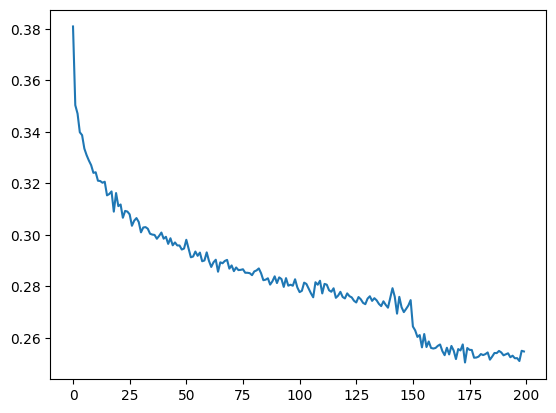

In [68]:
# much better
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [69]:
# put layers into eval mode (needed for bn specifically)
for layer in model.layers:
    layer.training = False

In [70]:
# evaluate the loss
@torch.no_grad()    # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.7670259475708008
dev 1.9914236068725586


In [55]:
# Sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size    # initialise will all '...'

    while True:
        # Forward pass the NN
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # Shift the context window
        context = context[1:] + [ix]
        out.append(ix)

        # If we sample '.' token, break
        if ix == 0:
            break

    print(''.join([itos[char] for char in out]))


arthanh.
asadara.
therion.
ipdi.
elizu.
jefoncey.
elmy.
jenelle.
gimmers.
adidani.
adierna.
s.
carison.
finla.
miko.
vorah.
braylox.
caturn.
leameil.
emmaomer.
